# Primavera Companion: Make your personalized Primavera Sound schedule

In [1]:
# pip install -r requirements.txt

In [1]:
import os
import sys
import json
import pandas as pd
from time import sleep
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR

## Process Playlists

Since Spotify has removed the endpoint to access the audio attributes, we obtained these values via an external tool manually and placed the required csv files in the "data" folder.

In [34]:
# ----- Data Loading and Initial Exploration -----
def load_and_explore_data():
    """Load the data files and perform initial exploration"""
    # Check if data exists in expected location
    data_dir = "./data"
    if not os.path.exists(data_dir):
        print(f"Warning: {data_dir} directory not found. Using current directory.")
        data_dir = "."
    
    # Find CSV files - you might need to adjust filenames
    my_playlist_path = None
    primavera_playlist_path = None
    
    for file in os.listdir(data_dir):
        if file.endswith('.csv'):
            if 'my' in file.lower() or 'personal' in file.lower() or 'taste' in file.lower() or 'matrix' in file.lower():
                my_playlist_path = os.path.join(data_dir, file)
            elif 'primavera' in file.lower() or 'festival' in file.lower():
                primavera_playlist_path = os.path.join(data_dir, file)
    
    if not my_playlist_path:
        my_playlist_path = input("Enter the path to your personal playlist CSV: ")
    if not primavera_playlist_path:
        primavera_playlist_path = input("Enter the path to the Primavera playlist CSV: ")
    
    # Load datasets
    print(f"Loading personal playlist from: {my_playlist_path}")
    my_playlist = pd.read_csv(my_playlist_path)
    
    print(f"Loading Primavera playlist from: {primavera_playlist_path}")
    primavera_playlist = pd.read_csv(primavera_playlist_path)
    
    # Basic exploration
    print("\n----- Personal Playlist Summary -----")
    print(f"Number of tracks: {len(my_playlist)}")
    print(f"Number of unique artists: {my_playlist['Artist Name(s)'].str.split(', ').explode().nunique()}")
    print(f"Columns available: {my_playlist.columns.tolist()}")
    
    print("\n----- Primavera Playlist Summary -----")
    print(f"Number of tracks: {len(primavera_playlist)}")
    print(f"Number of unique artists: {primavera_playlist['Artist Name(s)'].str.split(', ').explode().nunique()}")
    print(f"Columns available: {primavera_playlist.columns.tolist()}")
    
    return my_playlist, primavera_playlist


In [45]:
# ----- Data Preprocessing with Featured Artist Handling -----
def preprocess_playlist_data(playlist_df, is_training=True, shared_genres=None, return_genres=False, min_artist_frequency=None):
    """
    Preprocess playlist data for artist-level aggregation.
    - Explode artist collaborations into separate rows
    - Extract and encode genres
    - Aggregate numerical features by artist
    - Filter out infrequent artists (for Primavera data)
    
    Args:
        playlist_df: DataFrame containing playlist data
        is_training: Whether this is training data (True) or test data (False)
        shared_genres: List of shared genres to use (for test data)
        return_genres: Whether to return genre frequency info (True for initial training)
        min_artist_frequency: Minimum frequency for artists to be included (None = no filtering)
    """
    print(f"\n----- Preprocessing {'training' if is_training else 'test'} data -----")
    
    # Make a copy to avoid modifying the original DataFrame
    df = playlist_df.copy()
    
    # Check for needed columns and handle missing ones
    required_columns = [
        'Artist Name(s)', 'Genres', 'Popularity', 'Danceability', 'Energy', 
        'Key', 'Loudness', 'Mode', 'Speechiness', 'Acousticness', 
        'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Time Signature'
    ]
    
    for col in required_columns:
        if col not in df.columns:
            print(f"Warning: Column '{col}' not found. Adding dummy column.")
            if col in ['Key', 'Mode', 'Time Signature']:
                df[col] = 0  # Default for categorical
            else:
                df[col] = np.nan  # Default for numerical
    
    # Handle missing values in numeric columns
    numeric_cols = [
        'Popularity', 'Danceability', 'Energy', 'Loudness', 
        'Speechiness', 'Acousticness', 'Instrumentalness', 
        'Liveness', 'Valence', 'Tempo'
    ]
    
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        if df[col].isna().any():
            median_val = df[col].median()
            print(f"Filling {df[col].isna().sum()} missing values in '{col}' with median: {median_val:.2f}")
            df[col].fillna(median_val, inplace=True)
    
    # Convert categorical columns to integers to avoid type issues
    for col in ['Key', 'Mode', 'Time Signature']:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)
    
    # Explode artists to create one row per artist
    print("Exploding multiple artists in collaborations...")
    df['Artist Name(s)'] = df['Artist Name(s)'].astype(str)
    
    # Handle different separators for artist names (comma or comma+space)
    artist_lists = []
    for artists_str in df['Artist Name(s)']:
        if pd.isna(artists_str) or artists_str == '' or artists_str.lower() == 'nan':
            artist_lists.append([])
        else:
            if ', ' in artists_str:
                artist_lists.append([a.strip() for a in artists_str.split(', ') if a.strip()])
            else:
                artist_lists.append([a.strip() for a in artists_str.split(',') if a.strip()])
    
    df['Artist_List'] = artist_lists
    
    # Explode the dataframe on the artist list
    exploded_artists = df.explode('Artist_List')
    
    # Rename and clean up
    exploded_artists.rename(columns={'Artist_List': 'Artist'}, inplace=True)
    
    # Handle empty or NaN artist names
    exploded_artists = exploded_artists[exploded_artists['Artist'].notna() & (exploded_artists['Artist'] != '')]
    
    # Filter out infrequent artists if min_artist_frequency is specified (for Primavera data)
    if min_artist_frequency is not None and min_artist_frequency > 0:
        artist_counts = exploded_artists['Artist'].value_counts()
        frequent_artists = artist_counts[artist_counts >= min_artist_frequency].index
        
        original_count = exploded_artists['Artist'].nunique()
        exploded_artists = exploded_artists[exploded_artists['Artist'].isin(frequent_artists)]
        
        new_count = exploded_artists['Artist'].nunique()
        print(f"Filtered out {original_count - new_count} infrequent artists")
        print(f"Keeping {new_count} main artists with at least {min_artist_frequency} tracks")
        
        # If we filtered out all artists, that's a problem
        if len(exploded_artists) == 0:
            print("WARNING: All artists were filtered out. Reducing min_artist_frequency.")
            # Try with a lower threshold
            min_artist_frequency = 1
            exploded_artists = df.explode('Artist_List')
            exploded_artists.rename(columns={'Artist_List': 'Artist'}, inplace=True)
            exploded_artists = exploded_artists[exploded_artists['Artist'].notna() & (exploded_artists['Artist'] != '')]
    
    # Process genres - improved handling for different formats
    print("Processing genres...")
    
    # Check if Genres column exists, create it if it doesn't
    if 'Genres' not in exploded_artists.columns:
        print("Warning: 'Genres' column not found. Creating empty column.")
        exploded_artists['Genres'] = ''
    
    # Ensure Genres column is string type
    exploded_artists['Genres'] = exploded_artists['Genres'].astype(str)
    
    # Handle different genre separators (comma or comma+space)
    # Some may use ',', others may use ', '
    genre_lists = []
    for genres_str in exploded_artists['Genres']:
        # Handle NaN, empty strings, and 'nan' string
        if pd.isna(genres_str) or genres_str == '' or genres_str.lower() == 'nan':
            genre_lists.append([])
        else:
            # Try splitting by comma and space, if that doesn't work, try just comma
            if ', ' in genres_str:
                genre_lists.append([g.strip() for g in genres_str.split(', ') if g.strip()])
            else:
                genre_lists.append([g.strip() for g in genres_str.split(',') if g.strip()])
    
    exploded_artists['Genre_List'] = genre_lists
    
    # Calculate genre frequencies for training data
    if is_training and return_genres:
        # Flatten all genre lists
        all_genres_flat = [genre for sublist in genre_lists for genre in sublist if genre]
        
        # Count genre frequencies
        genre_counts = pd.Series(all_genres_flat).value_counts()
        
        print(f"Found {len(genre_counts)} unique genres in training data")
        print(f"Top 5 genres: {genre_counts.head(5).to_dict()}")
    
    # If shared_genres is provided, use only those genres
    # Otherwise, use all genres if in training mode
    if shared_genres is not None:
        genres_to_use = shared_genres
        print(f"Using {len(genres_to_use)} shared genres from both datasets")
    elif is_training:
        # Extract all unique genres
        all_genres = set()
        for genre_list in genre_lists:
            all_genres.update(genre_list)
        
        # Remove any empty strings
        if '' in all_genres:
            all_genres.remove('')
        
        genres_to_use = all_genres
        print(f"Using all {len(genres_to_use)} unique genres in training data")
    else:
        # This should not happen if code is used correctly
        print("WARNING: No shared_genres provided for test data. Using empty set.")
        genres_to_use = set()
    
    # Create dummy variables for genres (one-hot encoding)
    for genre in genres_to_use:
        exploded_artists[f'Genre_{genre}'] = exploded_artists['Genre_List'].apply(
            lambda x: 1 if genre in x else 0
        )
    
    # Drop the temporary Genre_List column
    exploded_artists.drop('Genre_List', axis=1, inplace=True)
    
    # Count tracks per artist (for training data)
    if is_training:
        print("Calculating artist frequency in personal playlist...")
        artist_frequency = exploded_artists['Artist'].value_counts().reset_index()
        artist_frequency.columns = ['Artist', 'Track_Count']
    
    # Aggregate numerical features by artist
    print("Aggregating features by artist...")
    
    # List of numerical features to aggregate
    num_features = [
        'Popularity', 'Danceability', 'Energy', 'Loudness', 'Speechiness',
        'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo'
    ]
    
    # Create aggregation dictionary
    agg_dict = {}
    for feature in num_features:
        agg_dict[feature] = ['min', 'max', 'mean', 'var']
    
    # Add genre columns to aggregation (using max because they're 0/1)
    genre_cols = [col for col in exploded_artists.columns if col.startswith('Genre_')]
    for col in genre_cols:
        agg_dict[col] = 'max'  # Just use 'max' without renaming
        
    # Add categorical columns with mode aggregation
    for col in ['Key', 'Mode', 'Time Signature']:
        agg_dict[col] = lambda x: x.mode().iloc[0] if not x.empty and len(x.mode()) > 0 else 0
    
    # Perform aggregation
    artist_features = exploded_artists.groupby('Artist').agg(agg_dict)
    
    # Flatten multi-level column names, but preserve genre column names WITHOUT _max suffix
    new_columns = []
    for col in artist_features.columns:
        if col[0].startswith('Genre_') and col[1] == 'max':
            # For genre columns, just use the original name without the _max suffix
            new_columns.append(col[0])
        else:
            # For other columns, join the names
            new_columns.append('_'.join(col).strip())
    
    artist_features.columns = new_columns
    
    # Reset index to make 'Artist' a column
    artist_features.reset_index(inplace=True)
    
    # For training data, merge with track count
    if is_training:
        artist_features = artist_features.merge(artist_frequency, on='Artist', how='left')
        artist_features['Track_Count'].fillna(0, inplace=True)
        print(f"Created features for {len(artist_features)} artists with track count as target variable")
    else:
        print(f"Created features for {len(artist_features)} artists")
    
    # Return the processed data, and genre counts if requested
    if is_training and return_genres:
        return artist_features, genre_counts
    return artist_features

In [36]:
# ----- Model Training and Evaluation -----
def train_and_evaluate_models(train_data):
    """Train multiple regression models and evaluate their performance"""
    print("\n----- Training and Evaluating Models -----")
    
    # Separate features and target
    X = train_data.drop(['Artist', 'Track_Count'], axis=1)
    y = train_data['Track_Count']
    
    # Fill any remaining NaN values
    X = X.fillna(0)
    
    # Initialize models to try
    models = {
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=0.1),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'SVR': SVR(kernel='rbf')
    }
    
    # Train and evaluate each model
    results = {}
    for name, model in models.items():
        print(f"Training {name}...")
        
        # Train with cross-validation
        cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
        rmse_scores = np.sqrt(-cv_scores)
        
        # Train on full dataset for later prediction
        model.fit(X, y)
        
        # Store results
        results[name] = {
            'model': model,
            'cv_rmse_mean': rmse_scores.mean(),
            'cv_rmse_std': rmse_scores.std()
        }
        
        print(f"  {name} - RMSE: {rmse_scores.mean():.4f} (±{rmse_scores.std():.4f})")
    
    # Find best model
    best_model_name = min(results, key=lambda k: results[k]['cv_rmse_mean'])
    print(f"\nBest performing model: {best_model_name} with RMSE: {results[best_model_name]['cv_rmse_mean']:.4f}")
    
    # Feature importance for tree-based models
    if 'Random Forest' in results:
        rf_model = results['Random Forest']['model']
        feature_importance = pd.DataFrame({
            'Feature': X.columns,
            'Importance': rf_model.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        print("\nTop 10 most important features (Random Forest):")
        print(feature_importance.head(10))
    
    return results

In [37]:
# ----- Prediction and Ranking -----
def predict_and_rank_artists(test_data, model_results):
    """Predict scores for test artists and rank them"""
    print("\n----- Predicting and Ranking Artists -----")
    
    # Prepare test features
    X_test = test_data.drop(['Artist'], axis=1)
    
    # Fill any remaining NaN values
    X_test = X_test.fillna(0)
    
    # Use the best model for prediction
    best_model_name = min(model_results, key=lambda k: model_results[k]['cv_rmse_mean'])
    best_model = model_results[best_model_name]['model']
    
    print(f"Using {best_model_name} for prediction...")
    
    # Predict scores
    test_data_copy = test_data.copy()
    test_data_copy['Predicted_Score'] = best_model.predict(X_test)
    
    # Ensure no negative scores
    test_data_copy['Predicted_Score'] = test_data_copy['Predicted_Score'].clip(lower=0)
    
    # Rank artists by predicted score
    ranked_artists = test_data_copy[['Artist', 'Predicted_Score']].sort_values(
        'Predicted_Score', ascending=False
    ).reset_index(drop=True)
    
    # Add rank column
    ranked_artists['Rank'] = ranked_artists.index + 1
    
    # Reorder columns
    ranked_artists = ranked_artists[['Rank', 'Artist', 'Predicted_Score']]
    
    print("\nTop 20 recommended artists from Primavera:")
    print(ranked_artists.head(20))
    
    return ranked_artists, test_data_copy

In [38]:
# ----- Artist Overlap Analysis -----
def analyze_artist_overlap(ranked_artists, my_playlist_df, primavera_playlist_df):
    """Analyze overlap between personal playlist and Primavera artists"""
    print("\n----- Analyzing Artist Overlap -----")
    
    # Extract all artists from personal playlist
    my_artists = set(my_playlist_df['Artist Name(s)'].str.split(', ').explode().unique())
    
    # Check which Primavera artists are in my playlist
    ranked_artists['In_My_Playlist'] = ranked_artists['Artist'].apply(
        lambda x: 1 if x in my_artists else 0
    )
    
    # Count overlap
    overlap_count = ranked_artists['In_My_Playlist'].sum()
    print(f"Found {overlap_count} Primavera artists in your personal playlist")
    
    # Highlight artists in common
    if overlap_count > 0:
        print("\nPrimavera artists in your playlist:")
        overlap_artists = ranked_artists[ranked_artists['In_My_Playlist'] == 1]
        print(overlap_artists[['Rank', 'Artist', 'Predicted_Score']])
    
    # Adjust scores based on overlap
    if overlap_count > 0:
        # Find maximum predicted score for normalization
        max_score = ranked_artists['Predicted_Score'].max()
        
        # Apply weight to overlap (0.5 means 50% of the score comes from model, 50% from playlist overlap)
        overlap_weight = 0.3  # You can adjust this
        
        print(f"\nAdjusting scores with overlap weight of {overlap_weight:.1f}")
        
        # Create adjusted score
        ranked_artists['Adjusted_Score'] = (
            (1 - overlap_weight) * ranked_artists['Predicted_Score'] + 
            overlap_weight * max_score * ranked_artists['In_My_Playlist']
        )
        
        # Re-rank based on adjusted score
        ranked_artists = ranked_artists.sort_values(
            'Adjusted_Score', ascending=False
        ).reset_index(drop=True)
        
        # Update rank
        ranked_artists['Adjusted_Rank'] = ranked_artists.index + 1
        
        print("\nTop 20 artists after adjustment:")
        print(ranked_artists[['Adjusted_Rank', 'Artist', 'Predicted_Score', 
                             'In_My_Playlist', 'Adjusted_Score']].head(20))
    
    return ranked_artists


In [39]:
# ----- Generate Attendance Spreadsheet -----
def generate_attendance_sheet(ranked_artists):
    """Generate an Excel sheet for marking attendance"""
    print("\n----- Generating Attendance Spreadsheet -----")
    
    # Create a simplified dataframe
    attendance_df = ranked_artists[['Artist']].copy()
    attendance_df['is_attending'] = ''  # Empty column for manual editing
    
    # Save to Excel
    output_file = 'primavera_attendance_sheet.xlsx'
    attendance_df.to_excel(output_file, index=False)
    
    print(f"Attendance sheet saved as '{output_file}'")
    print("You can now manually edit this file to mark artists you definitely want to see.")
    
    return output_file


In [40]:
# ----- Additional Visualizations -----
def create_visualizations(train_data, test_data, ranked_artists):
    """Create some visualizations for better understanding"""
    print("\n----- Creating Visualizations -----")
    
    # Set up the visualization style
    sns.set(style="whitegrid")
    
    # 1. Distribution of track counts
    plt.figure(figsize=(12, 6))
    sns.histplot(train_data['Track_Count'], kde=True)
    plt.title('Distribution of Track Counts in Personal Playlist')
    plt.xlabel('Number of Tracks per Artist')
    plt.ylabel('Count')
    plt.savefig('track_count_distribution.png')
    print("Saved 'track_count_distribution.png'")
    
    # 2. Feature correlation heatmap
    plt.figure(figsize=(16, 14))
    numeric_features = train_data.select_dtypes(include=['float64', 'int64']).columns
    correlation = train_data[numeric_features].corr()
    mask = np.triu(correlation)
    sns.heatmap(correlation, annot=False, mask=mask, cmap='coolwarm', 
                linewidths=0.5, vmin=-1, vmax=1)
    plt.title('Feature Correlation Heatmap')
    plt.tight_layout()
    plt.savefig('feature_correlation.png')
    print("Saved 'feature_correlation.png'")
    
    # 3. Top 20 recommended artists
    plt.figure(figsize=(14, 8))
    top20 = ranked_artists.head(20)
    ax = sns.barplot(x='Adjusted_Score' if 'Adjusted_Score' in ranked_artists.columns 
                    else 'Predicted_Score', 
                     y='Artist', data=top20)
    
    # Add color coding for artists in personal playlist
    if 'In_My_Playlist' in top20.columns:
        for i, artist in enumerate(top20['Artist']):
            color = 'darkgreen' if top20.iloc[i]['In_My_Playlist'] == 1 else 'darkblue'
            ax.patches[i].set_facecolor(color)
        
        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='darkgreen', label='In Your Playlist'),
            Patch(facecolor='darkblue', label='New Discovery')
        ]
        plt.legend(handles=legend_elements, loc='lower right')
    
    plt.title('Top 20 Recommended Primavera Artists')
    plt.xlabel('Score')
    plt.tight_layout()
    plt.savefig('top20_recommendations.png')
    print("Saved 'top20_recommendations.png'")
    
    # 4. Compare key audio features between personal and Primavera playlists
    plt.figure(figsize=(16, 12))
    
    features_to_compare = ['Danceability_mean', 'Energy_mean', 'Valence_mean', 
                          'Acousticness_mean', 'Instrumentalness_mean', 'Tempo_mean']
    
    for i, feature in enumerate(features_to_compare):
        plt.subplot(3, 2, i+1)
        
        # Personal playlist distribution
        sns.kdeplot(train_data[feature], label='Your Playlist', fill=True, alpha=0.3)
        
        # Primavera playlist distribution
        sns.kdeplot(test_data[feature], label='Primavera Playlist', fill=True, alpha=0.3)
        
        plt.title(f'Distribution of {feature.split("_")[0]}')
        plt.legend()
    
    plt.tight_layout()
    plt.savefig('feature_comparison.png')
    print("Saved 'feature_comparison.png'")
    
    return True


## Excution #1

In [20]:
print("===== Primavera Sound Artist Recommendation System =====")
import warnings
warnings.filterwarnings('ignore')

# Step 1: Load and explore data
my_playlist, primavera_playlist = load_and_explore_data()

# Step 2: Preprocess training data and get genres
train_data, known_genres = preprocess_playlist_data(my_playlist, is_training=True)

# Step 3: Preprocess test data with the same genres from training
test_data = preprocess_playlist_data(primavera_playlist, is_training=False, known_genres=known_genres)

# Save processed data
train_data.to_csv('processed_training_data.csv', index=False)
test_data.to_csv('processed_test_data.csv', index=False)
print("Saved processed data as CSV files")


===== Primavera Sound Artist Recommendation System =====
Loading personal playlist from: ./data\grand_matrix.csv
Loading Primavera playlist from: ./data\primavera_25.csv

----- Personal Playlist Summary -----
Number of tracks: 3375
Number of unique artists: 1445
Columns available: ['Track URI', 'Track Name', 'Album Name', 'Artist Name(s)', 'Release Date', 'Duration (ms)', 'Popularity', 'Added By', 'Added At', 'Genres', 'Record Label', 'Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Time Signature']

----- Primavera Playlist Summary -----
Number of tracks: 807
Number of unique artists: 216
Columns available: ['Track URI', 'Track Name', 'Album Name', 'Artist Name(s)', 'Release Date', 'Duration (ms)', 'Popularity', 'Added By', 'Added At', 'Genres', 'Record Label', 'Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Ti

In [21]:
# Step 4: Train and evaluate models
model_results, feature_columns = train_and_evaluate_models(train_data)

# Step 5: Predict and rank artists
ranked_artists, predicted_test_data = predict_and_rank_artists(
    test_data, model_results, feature_columns
)



----- Training and Evaluating Models -----
Training Ridge Regression...
  Ridge Regression - RMSE: 3.1045 (±0.8757)
Training Lasso Regression...
  Lasso Regression - RMSE: 3.1400 (±1.1754)
Training Random Forest...
  Random Forest - RMSE: 2.8748 (±0.8214)
Training Gradient Boosting...
  Gradient Boosting - RMSE: 2.3710 (±0.6525)
Training SVR...
  SVR - RMSE: 4.3703 (±1.4782)

Best performing model: Gradient Boosting with RMSE: 2.3710

Top 10 most important features (Random Forest):
             Feature  Importance
29      Liveness_max    0.158006
28      Liveness_min    0.135978
11        Energy_var    0.099498
9         Energy_max    0.050172
36         Tempo_min    0.046985
20  Acousticness_min    0.042508
13      Loudness_max    0.036216
16   Speechiness_min    0.036019
15      Loudness_var    0.034609
31      Liveness_var    0.034595

----- Predicting and Ranking Artists -----


TypeError: Cannot setitem on a Categorical with a new category (0), set the categories first

In [ ]:
# Step 6: Analyze artist overlap
ranked_artists = analyze_artist_overlap(
    ranked_artists, my_playlist, primavera_playlist
)

# Step 7: Generate attendance sheet
attendance_file = generate_attendance_sheet(ranked_artists)

# Step 8: Create visualizations
create_visualizations(train_data, predicted_test_data, ranked_artists)

# Save final rankings
ranking_file = 'primavera_artist_rankings.csv'
ranked_artists.to_csv(ranking_file, index=False)
print(f"\nSaved final artist rankings to '{ranking_file}'")

print("\n===== Processing Complete =====")
print(f"Check out the recommendations in '{ranking_file}'")
print(f"Use '{attendance_file}' to mark which artists you plan to see")
print("Visualizations have been saved as PNG files")

## Execution #2

In [46]:

print("===== Primavera Sound Artist Recommendation System =====")

# Step 1: Load and explore data
my_playlist, primavera_playlist = load_and_explore_data()

# Step 2: First pass of data processing to get genres from both datasets
print("\n----- First pass: Analyzing genres in both datasets -----")
_, my_genres = preprocess_playlist_data(my_playlist, is_training=True, return_genres=True)

# Do a light processing of Primavera data to get genres
primavera_exploded = primavera_playlist.copy()
primavera_exploded['Genres'] = primavera_exploded['Genres'].astype(str)

# Extract genres from Primavera data
primavera_genre_lists = []
for genres_str in primavera_exploded['Genres']:
    if pd.isna(genres_str) or genres_str == '' or genres_str.lower() == 'nan':
        primavera_genre_lists.append([])
    else:
        if ', ' in genres_str:
            primavera_genre_lists.append([g.strip() for g in genres_str.split(', ') if g.strip()])
        else:
            primavera_genre_lists.append([g.strip() for g in genres_str.split(',') if g.strip()])

# Flatten all genre lists from Primavera
primavera_genres_flat = [genre for sublist in primavera_genre_lists for genre in sublist if genre]

# Count genre frequencies in Primavera data
primavera_genre_counts = pd.Series(primavera_genres_flat).value_counts()

# Find genres that appear in both datasets
my_genre_set = set(my_genres.index)
primavera_genre_set = set(primavera_genre_counts.index)
shared_genres = my_genre_set.intersection(primavera_genre_set)

print(f"Found {len(shared_genres)} genres shared between datasets")

# Get the top 20 most frequent genres from your playlist that also appear in Primavera data
top_shared_genres = my_genres[my_genres.index.isin(shared_genres)].nlargest(20).index.tolist()

print(f"Selected top 20 shared genres: {top_shared_genres}")

# Step 3: Actual data preprocessing with selected genres
# For personal playlist - no minimum frequency filtering
train_data = preprocess_playlist_data(my_playlist, is_training=True, shared_genres=top_shared_genres)

# For Primavera playlist - apply minimum frequency filtering to remove featured artists
# Use min_artist_frequency=5 to filter out artists with fewer than 5 tracks (likely features)
test_data = preprocess_playlist_data(
    primavera_playlist, 
    is_training=False, 
    shared_genres=top_shared_genres,
    min_artist_frequency=5
)

# Save processed data
train_data.to_csv('processed_training_data.csv', index=False)
test_data.to_csv('processed_test_data.csv', index=False)
print("Saved processed data as CSV files")

===== Primavera Sound Artist Recommendation System =====
Loading personal playlist from: ./data\grand_matrix.csv
Loading Primavera playlist from: ./data\primavera_25.csv

----- Personal Playlist Summary -----
Number of tracks: 3375
Number of unique artists: 1445
Columns available: ['Track URI', 'Track Name', 'Album Name', 'Artist Name(s)', 'Release Date', 'Duration (ms)', 'Popularity', 'Added By', 'Added At', 'Genres', 'Record Label', 'Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Time Signature']

----- Primavera Playlist Summary -----
Number of tracks: 807
Number of unique artists: 216
Columns available: ['Track URI', 'Track Name', 'Album Name', 'Artist Name(s)', 'Release Date', 'Duration (ms)', 'Popularity', 'Added By', 'Added At', 'Genres', 'Record Label', 'Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Ti

In [47]:
# Step 4: Train and evaluate models
model_results = train_and_evaluate_models(train_data)

# Step 5: Predict and rank artists
ranked_artists, predicted_test_data = predict_and_rank_artists(test_data, model_results)

# Step 6: Analyze artist overlap
ranked_artists = analyze_artist_overlap(
    ranked_artists, my_playlist, primavera_playlist
)


----- Training and Evaluating Models -----
Training Ridge Regression...
  Ridge Regression - RMSE: 2.9732 (±1.0081)
Training Lasso Regression...
  Lasso Regression - RMSE: 3.1400 (±1.1754)
Training Random Forest...
  Random Forest - RMSE: 2.8003 (±0.7866)
Training Gradient Boosting...
  Gradient Boosting - RMSE: 2.2629 (±0.7062)
Training SVR...
  SVR - RMSE: 4.3703 (±1.4781)

Best performing model: Gradient Boosting with RMSE: 2.2629

Top 10 most important features (Random Forest):
             Feature  Importance
29      Liveness_max    0.160700
28      Liveness_min    0.139001
11        Energy_var    0.101565
36         Tempo_min    0.055252
9         Energy_max    0.054796
13      Loudness_max    0.041093
20  Acousticness_min    0.039568
31      Liveness_var    0.035940
15      Loudness_var    0.034916
16   Speechiness_min    0.034030

----- Predicting and Ranking Artists -----
Using Gradient Boosting for prediction...

Top 20 recommended artists from Primavera:
    Rank           

In [48]:
# Step 7: Generate attendance sheet
attendance_file = generate_attendance_sheet(ranked_artists)


----- Generating Attendance Spreadsheet -----
Attendance sheet saved as 'primavera_attendance_sheet.xlsx'
You can now manually edit this file to mark artists you definitely want to see.



----- Creating Visualizations -----
Saved 'track_count_distribution.png'
Saved 'feature_correlation.png'
Saved 'top20_recommendations.png'
Saved 'feature_comparison.png'


True

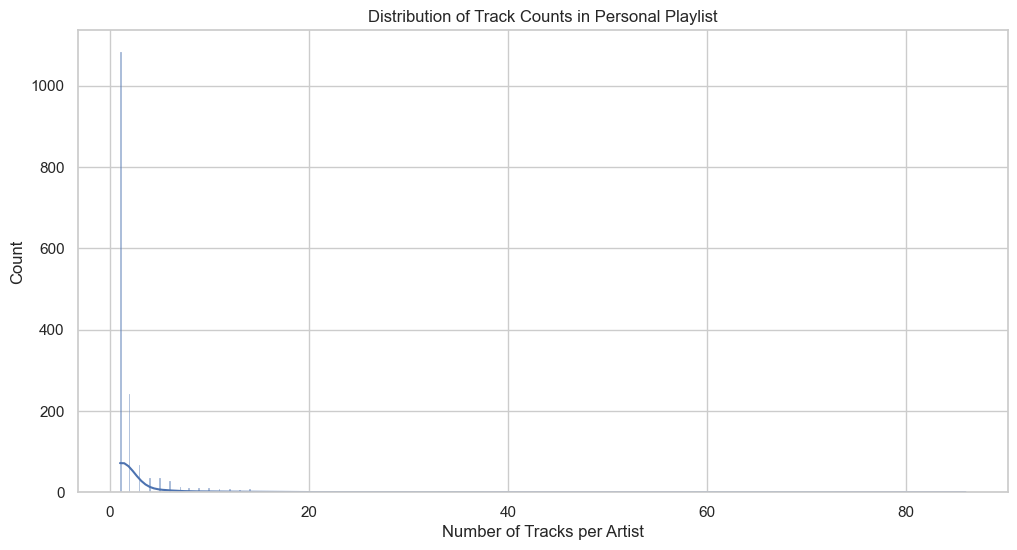

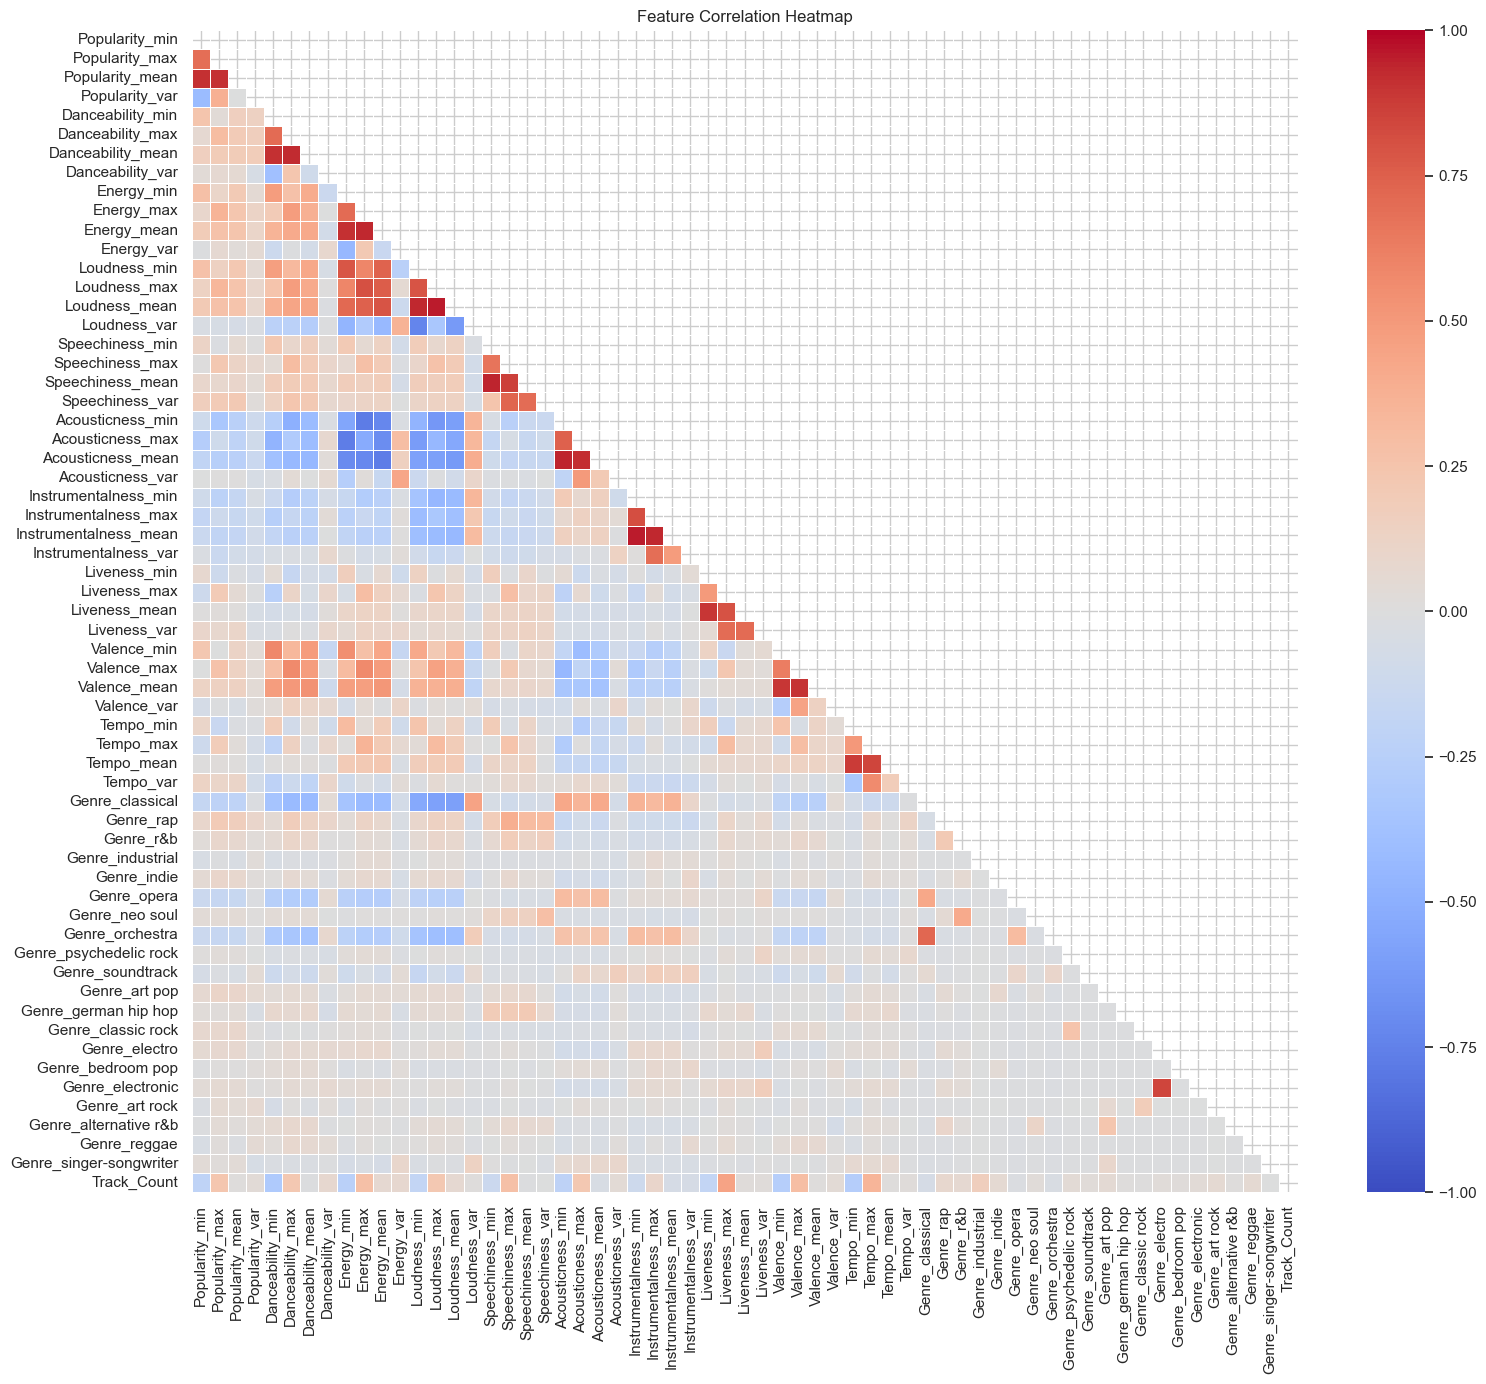

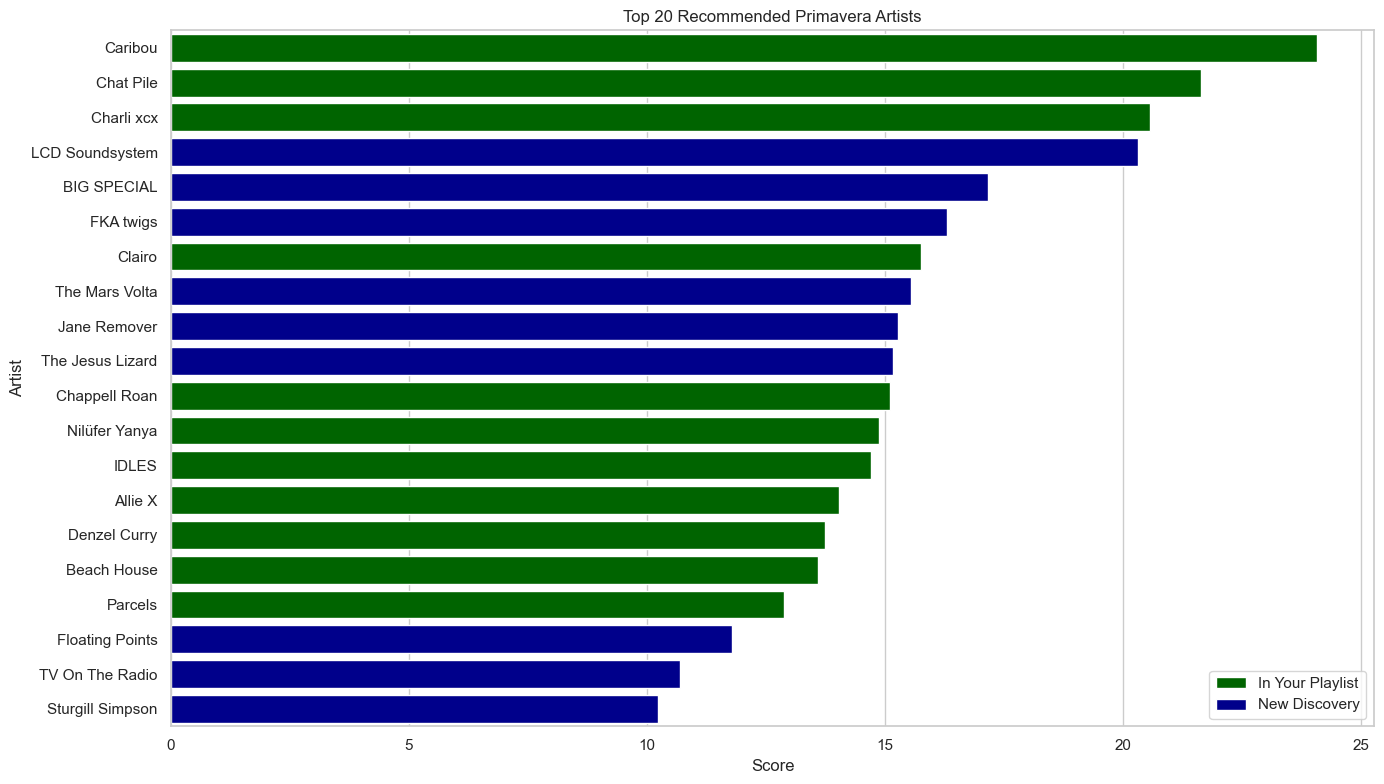

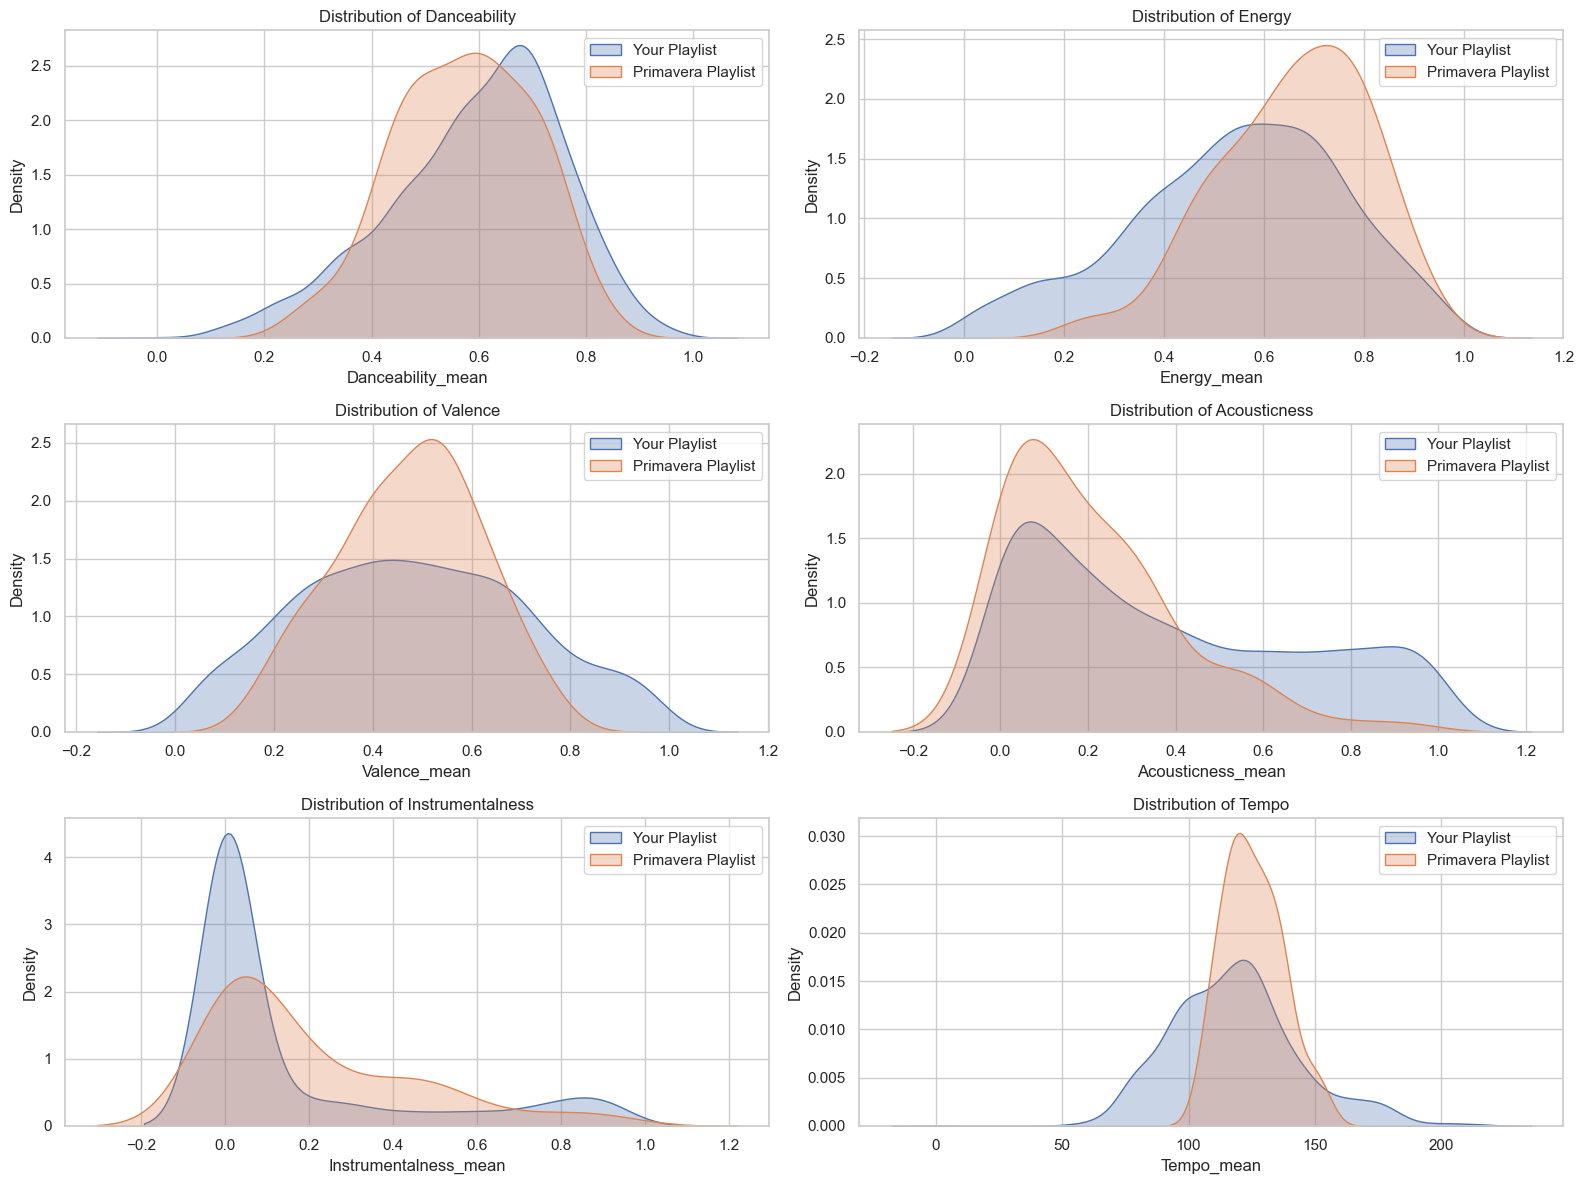

In [49]:
# Step 8: Create visualizations
create_visualizations(train_data, predicted_test_data, ranked_artists)

In [50]:

# Save final rankings
ranking_file = 'primavera_artist_rankings.csv'
ranked_artists.to_csv(ranking_file, index=False)
print(f"\nSaved final artist rankings to '{ranking_file}'")

print("\n===== Processing Complete =====")
print(f"Check out the recommendations in '{ranking_file}'")
print(f"Use '{attendance_file}' to mark which artists you plan to see")
print("Visualizations have been saved as PNG files")


Saved final artist rankings to 'primavera_artist_rankings.csv'

===== Processing Complete =====
Check out the recommendations in 'primavera_artist_rankings.csv'
Use 'primavera_attendance_sheet.xlsx' to mark which artists you plan to see
Visualizations have been saved as PNG files
